In [52]:
import pandas as pd
from matplotlib import pyplot as plt

In [53]:
log_pd = pd.read_csv('denoise.log')

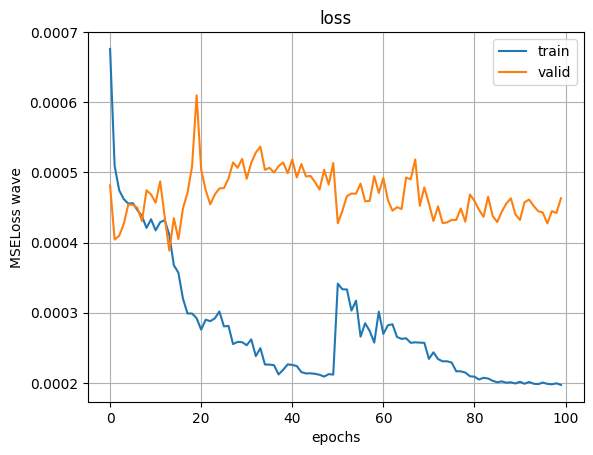

In [67]:
plt.title('loss')
plt.plot(log_pd[' train_loss'], label='train')
plt.plot(log_pd[' valid_loss'], label='valid')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSELoss wave')
plt.grid()

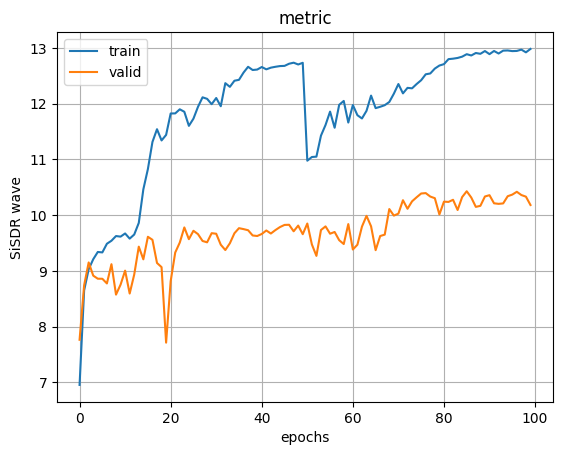

In [73]:
plt.title('metric')
plt.plot(log_pd[' train_metric'], label='train')
plt.plot(log_pd[' valid_metric'], label='valid')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('SiSDR wave')
plt.grid()

# AUDIO

In [1]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from unet import Unet_model
from Modules import STFT

In [2]:
from torch.utils.data import Dataset
import os
import torchaudio as ta
from IPython.display import Audio
torch.manual_seed(0)

def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise

class my_dataset(Dataset):
    def __init__(self, path):
        self.path_signal = os.listdir(f'{path}/mic')
        self.path_target = f'{path}/target'
        self.path_mic = f'{path}/mic'
        self.noise = torch.rand(1,53768)
        
    def __len__(self):
        return len(self.path_signal)
    
    def __getitem__(self, idx):
        path = self.path_signal[idx]
        
        target, sample_rate = ta.load(f'{self.path_target}/{path}')
        mic_array, sample_rate = ta.load(f'{self.path_mic}/{path}')
        
        target = F.pad(target, (0, mic_array.shape[-1] - target.shape[-1]))
        return  target, generate_mixture(target, torch.rand(1,target.shape[-1]), 5)

In [3]:
def plot_magn(magn, title):
    plt.title(title)
    plt.imshow(torch.log(magn+ 1e-5).detach(), cmap="viridis", origin="lower", aspect="auto")
    plt.show();
    
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

In [30]:
data_valid = my_dataset('./beam_data/valid')
data_train = my_dataset('./beam_data/train')

In [5]:
import torch as th

def pipline(model, sample):
    spec_sample = stft.stft(sample)
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)
    mask = model(spec_sample)
    mag_predict = mag * mask
    
    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, sample.shape[-1])
    return wave_predict

In [14]:
unet_mask = Unet_model()
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [20]:
checkpoint = torch.load('checkpoint_denoise.pt', map_location='cpu')
unet_mask.load_state_dict(checkpoint['model_state_dict'])
unet_mask.eval();

In [45]:
predict_wave = pipline(unet_mask, data_valid[0][1][None])

In [46]:
Audio(data_valid[0][0], rate=16000)

In [47]:
Audio(data_valid[0][1], rate=16000)

In [48]:
Audio(predict_wave.detach()[0], rate=16000)

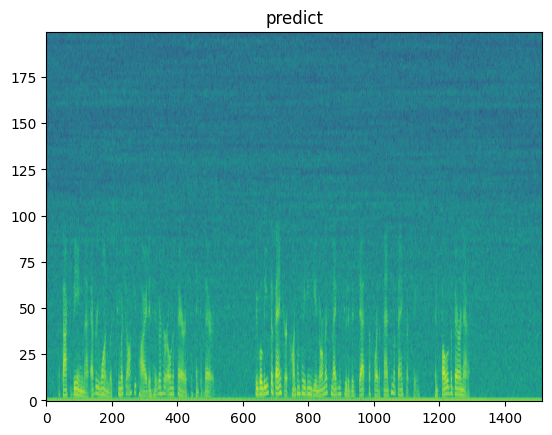

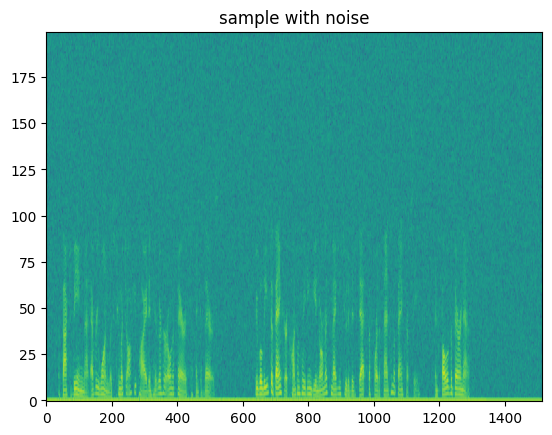

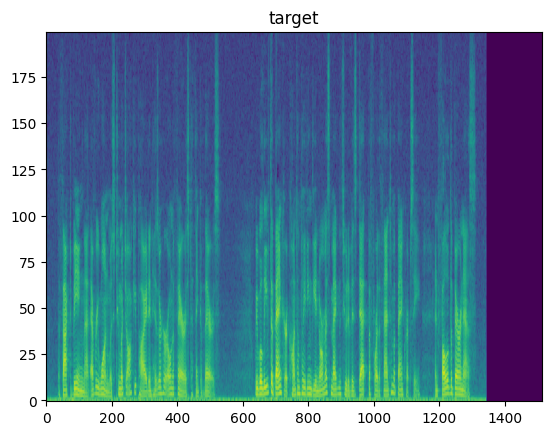

In [50]:
plot_magn(stft.stft(predict_wave.detach()[0]).abs()[0], 'predict')
plot_magn(stft.stft(data_valid[0][1]).abs()[0], 'sample with noise')
plot_magn(stft.stft(data_valid[0][0]).abs()[0], 'target')